In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


In [3]:
df = pd.read_csv("english.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3410 non-null   object
 1   label   3410 non-null   object
dtypes: object(2)
memory usage: 53.4+ KB


In [6]:
from sklearn.utils import resample

df =resample(df,n_samples=500,replace=False,random_state=42)

In [7]:
df.head()

,image,label
3135,Img/img058-001.png,v
1789,Img/img033-030.png,W
170,Img/img004-006.png,3
680,Img/img013-021.png,C
2803,Img/img051-054.png,o


In [8]:
df.isnull().sum()

image    0
label    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df["label"].value_counts()

label
3    17
s    14
7    14
4    13
5    13
     ..
J     4
Z     4
b     3
p     3
c     3
Name: count, Length: 62, dtype: int64

In [11]:
from PIL import Image
images = df["image"]
output=[]
for path in images:
    
    image = Image.open(path)
    image = image.convert("L")
    image = image.resize((500,500))
    image = np.array(image)
    output.append(image)

image_data = np.array(output)
image_data = image_data/255.0

print(image_data.shape)

(500, 500, 500)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Reshape, Conv2D, BatchNormalization, UpSampling2D

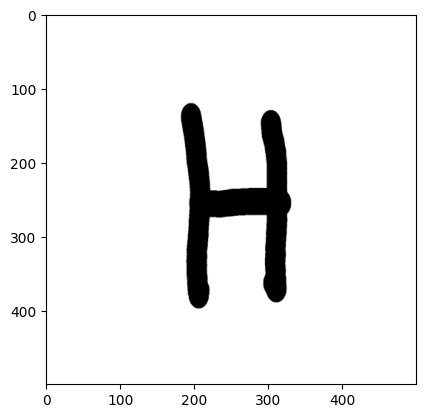

In [13]:
plt.gray()
plt.imshow(image_data[200])

In [14]:
text_data = df["label"]

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True,lower=False)
tokenizer.fit_on_texts(text_data)

# Convert text data to sequences
text_sequences = tokenizer.texts_to_sequences(text_data)

# Padding sequences for a consistent input size
max_text_length = max(len(seq) for seq in text_sequences)
padded_text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_text_length)

In [15]:
len(tokenizer.word_index)

62

In [16]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=20))
model.add(layers.LSTM(524))
model.add(layers.Dense(500*500, activation='relu'))
model.add(layers.Reshape((500, 500, 1)))  
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(np.array(padded_text_sequences), image_data, epochs=10, batch_size=64)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.9395
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.9257
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 0.9138
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 0.8983
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.8790
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.8509
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.7989
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.7039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 0.5383
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.3044


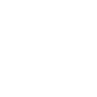

In [17]:
white_image = np.ones((500, 500)) * 255
fig,ax = plt.subplots(figsize = (1,1))
plt.axis('off')
plt.imshow(white_image,cmap='gray', vmin=0, vmax=255)
plt.show()

In [18]:
def get_out_image(text="Sample",figsize=(10,6),crop_size=(250,500)):
    
    mystr = text
    textlist = list(mystr)

    predicted_images=[]

    for new_text in textlist:
        if (new_text==" "):
            white_image = np.ones((500, 500))*249
            predicted_images.append(white_image)
        else:
            new_text_sequence = tokenizer.texts_to_sequences([new_text])
            predicted_image = model.predict(np.array(new_text_sequence),verbose=5)[0]
            predicted_image = predicted_image.reshape(500,500)
            predicted_images.append(predicted_image)

    directory_path = 'out_images'


    import os
    os.mkdir("out_images")

    predicted_images = np.array(predicted_images)

    for new_text,image in zip(textlist,predicted_images):
        image_path = f"out_images/{new_text}.png"
        fig = plt.figure(figsize=(5,5))
        if (new_text==" "):
            fig.figimage(image,vmin=0,vmax=255)
        else:
            fig.figimage(image)
        plt.savefig(image_path)
        plt.close(fig)


    def center_crop(image, target_size):
        width, height = image.size
        left = (width - target_size[0]) // 2
        top = (height - target_size[1]) // 2
        right = (width + target_size[0]) // 2
        bottom = (height + target_size[1]) // 2
        return image.crop((left, top, right, bottom))

    def merge_images(image_list):

        image_size = image_list[0].size
        merged_image = np.zeros((image_size[1], len(image_list) * image_size[0]))

        for i, image in enumerate(image_list):
            merged_image[:, i * image_size[0] : (i + 1) * image_size[0]] = np.array(image)

        return merged_image

    images = []
    for char in textlist:
        # Load image (replace 'path_to_images' with the actual path)
        image_path = f"out_images/{char}.png"
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        cropped_img = center_crop(img, target_size=crop_size)  # Adjust the target size as needed
        images.append(cropped_img)

    # Merge images into a single numpy array
    merged_image_array = merge_images(images)

    # Display the thresholded merged image
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(merged_image_array, cmap="gray",vmin=0, vmax=255)
    ax.axis("off")
    plt.show()


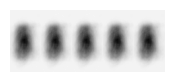

In [19]:
get_out_image("Apple",figsize=(2,3))
